In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr

In [3]:
import scipy.signal
import torch
from torch import nn
from torch.utils.data import DataLoader

In [4]:
from Game import Game
from Player import Player
from Event import Event
from Moment import Moment
from Ball import Ball

In [5]:
position_ids = torch.arange(1024)[:, None]
d = 512
a = (position_ids/(10000*2*np.pi/2/np.pi)**(torch.arange(d)/d)).sin()

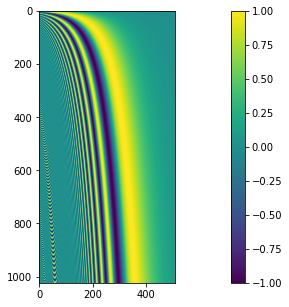

In [6]:
plt.figure(figsize=(20, 5))
plt.imshow(a.numpy()); plt.colorbar()

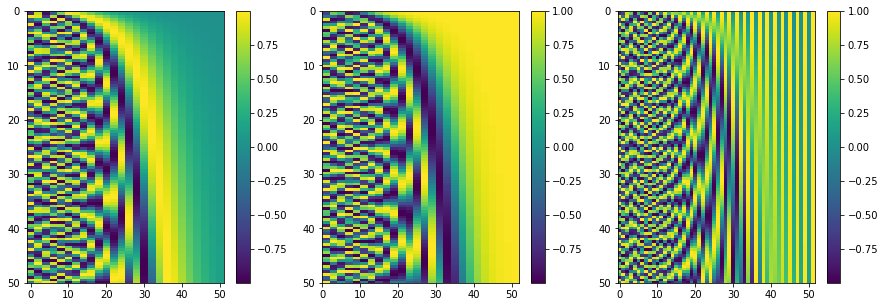

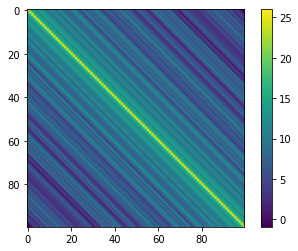

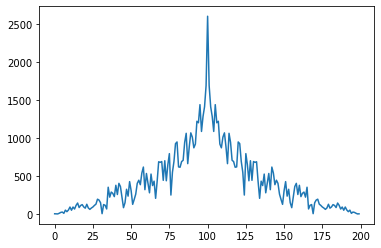

In [14]:
    
import util
a = util.fourier_pos(0, 50, t=torch.linspace(0, 50, 100), d=52, do_viz=True)
plt.imshow(a@a.T); plt.colorbar()
plt.show()
plt.plot([(a@a.T).diagonal(i).sum().item() for i in range(-100, 100)])
plt.show()

In [31]:
path = 'data/game2.json'
game = Game(path)
game.read_json(tqdm=tqdm)

loading  501


  0%|          | 0/501 [00:00<?, ?it/s]

In [140]:
game.team2onehot = {0: 0, game.home_team.id: 1, game.guest_team.id: 2}
print(len(team2onehot), team2onehot)
game.pid2onehot = {0: 0}
game.pid2onehot.update({a: idx+1 for idx, a in enumerate(game.player_ids_dict.keys())})
print(len(pid2onehot), pid2onehot)

3 {0: 0, 1610612745: 1, 1610612738: 2}
25 {0: 0, 2772: 1, 201951: 2, 203093: 3, 201977: 4, 2730: 5, 201935: 6, 203991: 7, 1891: 8, 203909: 9, 201147: 10, 1626149: 11, 202340: 12, 202738: 13, 203096: 14, 201973: 15, 202323: 16, 1626179: 17, 1626154: 18, 203935: 19, 203482: 20, 101135: 21, 203092: 22, 101161: 23, 203109: 24}


In [146]:
import preprocess
dg_raw = preprocess.load_data_game(game, tqdm=tqdm)
dg = preprocess.preprocess(dg_raw)
# list(zip([e.shape for e in dg_raw], [e[:, 2].sum() for e in dg_raw]))

  0%|          | 0/501 [00:00<?, ?it/s]

In [142]:
np.isnan(dg).any(axis=0)

array([False, False,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

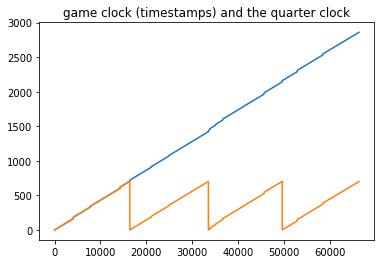

0.03 2861.14


AssertionError: timestamps not all decreasing

In [143]:
plt.plot(dg[:, 0])
plt.plot(dg[:, 1])
plt.title('game clock (timestamps) and the quarter clock')
plt.show()

t = dg[:, 0]
print(t.min(), t.max())
dt = np.diff(t)
assert (dt<0).all(), 'timestamps not all decreasing'
print(dt.min(), dt.mean(), dt.max())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(dt, bins=100);
plt.title('Distribution of dt')
plt.yscale('log')
plt.subplot(122)
plt.hist(dt[dt>-.1], bins=100);
# plt.yscale('log')
plt.show()

(-0.05, 0.0)

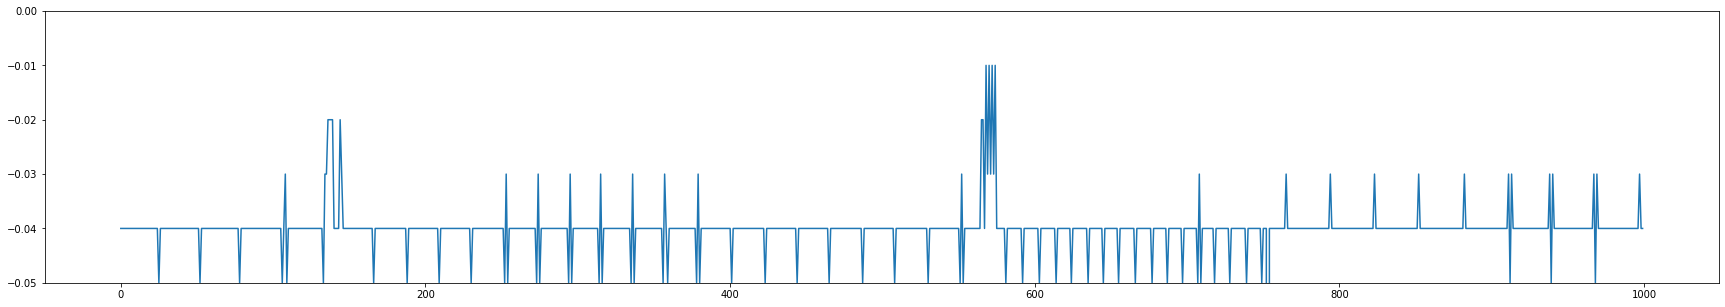

In [68]:
plt.figure(figsize=(30, 5))
plt.plot(dt[20000:21000])
plt.ylim(-.05, 0)

In [79]:
print(f"dt decreasing for {(dt<0.).sum()} frames and increasing for {(dt>=0.).sum()} frames")

dt decreasing for 66412 frames and increasing for 0 frames


(-3.4655285, 101.6141385, 6.304955500000001, 49.7933345)

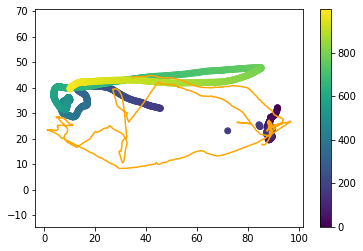

In [80]:
x = dg[:1000, 10]
y = dg[:1000, 11]
plt.scatter(x, y, c=np.arange(len(x)))
plt.colorbar()
x = dg[:1000, 5]
y = dg[:1000, 6]
plt.plot(x,y, color='orange')

plt.axis('equal')
# plt.ylim(0, 50)
# plt.xlim(0, 94)

In [40]:
import torch
from torch import nn

In [81]:
from collections import defaultdict

In [82]:
from constants import max_speed_ball, max_speed_human

In [191]:
from dataset import BasketballDataset

In [215]:
ds = BasketballDataset(game, dg, input_shot_clock=True, input_p_id=False, tqdm=tqdm)
# x_mean = ds.x.mean(axis=(0, 1))
# x_std = ds.x.std(axis=(0, 1))
# y_mean = ds.y.mean(axis=(0, 1))
# y_std = ds.y.std(axis=(0, 1))
# print([i.shape for i in ds[0]])
# print(len(ds))

starting
doing init
Creating dataset
Initial dataset size  torch.Size([997, 4, 48])
Eliminated 11 items for nan
Eliminated 85 items for bad dt
updated dataset size  torch.Size([901, 4, 48])
torch.Size([3, 11, 3]) torch.Size([3])
torch.Size([3])


In [266]:
import copy
def index_data_dict(data, mask):
    data = copy.copy(data)
    for key, value in data.items():
        if isinstance(value, torch.Tensor):
            data[key] = value[mask]
    return data
def print_data_dict(data):
    for key, value in data.items():
        print(f'{key}: {value.shape}', end=' | ')
    print(); print()
    
    
def init_ds(dg):
    idx_inp_xy = 2
    idx_inp_v = 1
    idx_inp_a = 0

    """
    . . . . x,y, :3  can be input
     . . . vx, vy :2 can be input
      . . ax, ay, :1 can be input, 1 is target
    """
    dg = torch.from_numpy(dg[:])
    ds = {}
    print('Creating dataset')
    
    idxs = sliding_window(4, len(dg))
    ds['dg_m'] = dg[idxs]
    del dg
    print_data_dict(ds)
                         
    # dg.shape is all_moments, context moment, features
    # dg.shape is 66000, 4, 48 (game_clock, quarter_clock, shot_clock, quarter, 0, bx, by, br, [p_id, team_id, x, y]*10)

    mask_nan = ds['dg_m'].isnan().any(dim=-1).any(dim=-1) # 66000
    print(f'Removing {mask_nan.sum().item()} frames for NaN values')
    ds = index_data_dict(ds, ~mask_nan)
    print_data_dict(ds)
    
    ds['t_m'] = ds['dg_m'][..., 0] # 66000, 4
    ds['dt_m'] = ds['t_m'].diff(dim=-1) # 66000, 3
    ds['dt'] = ds['dt_m'][..., idx_inp_v]
    mask_game = ((ds['dt_m']--0.04).abs()>1e-4).any(dim=-1) # 66000
    # do same mask with index 0, 1, 2
    print(f'Removing {mask_game.sum().item()} items for bad dt')
    ds = index_data_dict(ds, ~mask_game)
    print_data_dict(ds)

    shot_clock = ds['dg_m'][..., 2] # 66000, 4
    ds['t_shot'] = shot_clock[..., idx_inp_xy]
    
    bx, by, bz = ds['dg_m'][..., 5], ds['dg_m'][..., 6], ds['dg_m'][..., 7] # 66000, 4
    players = ds['dg_m'][..., 8:].reshape(*ds['dg_m'].shape[:-1], 10, 4) # 66000, 4, 10, 4
    id_p = players[..., 0] # 66000, 4, 10
    id_team = players[..., 1] # 66000, 4, 10
    # TODO: sort players by pid within each timestep
    mask_pid = (id_p.std(axis=1)<1e-3).all(dim=-1) # 66000
    mask_team = (id_team.std(axis=1)<1e-3).all(dim=-1) # 66000

    id_p, id_team = id_p[:, idx_inp_xy], id_team[:, idx_inp_xy] # 66000, 10
    id_p = torch.cat([torch.zeros(*id_p.shape[:-1], 1), id_p], dim=-1)
    id_team = torch.cat([torch.zeros(*id_team.shape[:-1], 1), id_team], dim=-1)
    id_p = id_p.int().apply_(game.pid2onehot.get)
    id_team = id_team.int().apply_(game.team2onehot.get)
    ds['id_p'], ds['id_team'] = id_p, id_team
    # oh_team = nn.functional.one_hot(id_team.long(), len(game.team2onehot))
    # oh_id = nn.functional.one_hot(id_p.long(), len(pid2onehot))
    print_data_dict(ds)

    x, y = players[..., 2], players[..., 3] # 66000, 4, 10
    z = torch.zeros_like(x) # 66000, 4, 10
    x = torch.cat([bx[..., None], x], dim=-1) # add ball as the first "player"
    y = torch.cat([by[..., None], y], dim=-1)
    z = torch.cat([bz[..., None], z], dim=-1) # 66000, 4, 11

    ds['x_m'] = torch.stack([x,y,z], axis=-1) # 66000, 4, 11, xyz
    dt = ds['dt'][..., None, None, None]
    ds['v_m'] = torch.diff(ds['x_m'], axis=-3)/dt
    ds['a_m'] = torch.diff(ds['v_m'], axis=-3)/dt/dt
    
    print_data_dict(ds)
    
    ds['x']  = ds['x_m'][..., idx_inp_xy, :, :]
    ds['nx'] = ds['x_m'][..., idx_inp_xy+1, :, :]
    ds['v']  = ds['v_m'][..., idx_inp_v, :, :]
    ds['nv'] = ds['v_m'][..., idx_inp_v+1, :, :]
    
    print_data_dict(ds)

    mask = (ds['v_m'][..., :, :1, :].norm(dim=-1)>max_speed_ball).all(dim=-1).all(dim=-1)
    print(f'Removing {mask.sum().item()} frames for high ball speed')
    ds = index_data_dict(ds, ~mask)
    mask = (ds['v_m'][..., :, 1:, :].norm(dim=-1)>max_speed_human).all(dim=-1).all(dim=-1)
    print(f'Removing {mask.sum().item()} frames for high player speed')
    ds = index_data_dict(ds, ~mask)
    
    print_data_dict(ds)
    
    # a1 = torch.logical_and(self.y[:, :, 0]>=0., self.y[:, :, 1]>=0.)
    # a2 = torch.logical_and(self.y[:, :, 0]>=0., self.y[:, :, 1]<0.)
    # a3 = torch.logical_and(self.y[:, :, 0]<0., self.y[:, :, 1]>=0.)
    # a4 = torch.logical_and(self.y[:, :, 0]<0., self.y[:, :, 1]<0.)
    # self.y = torch.stack([a1, a2, a3, a4], dim=-1).float().argmax(dim=-1)
    
init_ds(dg)

Creating dataset
dg_m: torch.Size([66410, 4, 48]) | 

Removing 2150 frames for NaN values
dg_m: torch.Size([64260, 4, 48]) | 

Removing 9941 items for bad dt
dg_m: torch.Size([54319, 4, 48]) | t_m: torch.Size([54319, 4]) | dt_m: torch.Size([54319, 3]) | dt: torch.Size([54319]) | 

dg_m: torch.Size([54319, 4, 48]) | t_m: torch.Size([54319, 4]) | dt_m: torch.Size([54319, 3]) | dt: torch.Size([54319]) | t_shot: torch.Size([54319]) | id_p: torch.Size([54319, 11]) | id_team: torch.Size([54319, 11]) | 

dg_m: torch.Size([54319, 4, 48]) | t_m: torch.Size([54319, 4]) | dt_m: torch.Size([54319, 3]) | dt: torch.Size([54319]) | t_shot: torch.Size([54319]) | id_p: torch.Size([54319, 11]) | id_team: torch.Size([54319, 11]) | x_m: torch.Size([54319, 4, 11, 3]) | v_m: torch.Size([54319, 3, 11, 3]) | a_m: torch.Size([54319, 2, 11, 3]) | 

dg_m: torch.Size([54319, 4, 48]) | t_m: torch.Size([54319, 4]) | dt_m: torch.Size([54319, 3]) | dt: torch.Size([54319]) | t_shot: torch.Size([54319]) | id_p: torch.S

[-1.5 -1.5] [1.5 1.5] [10 10]


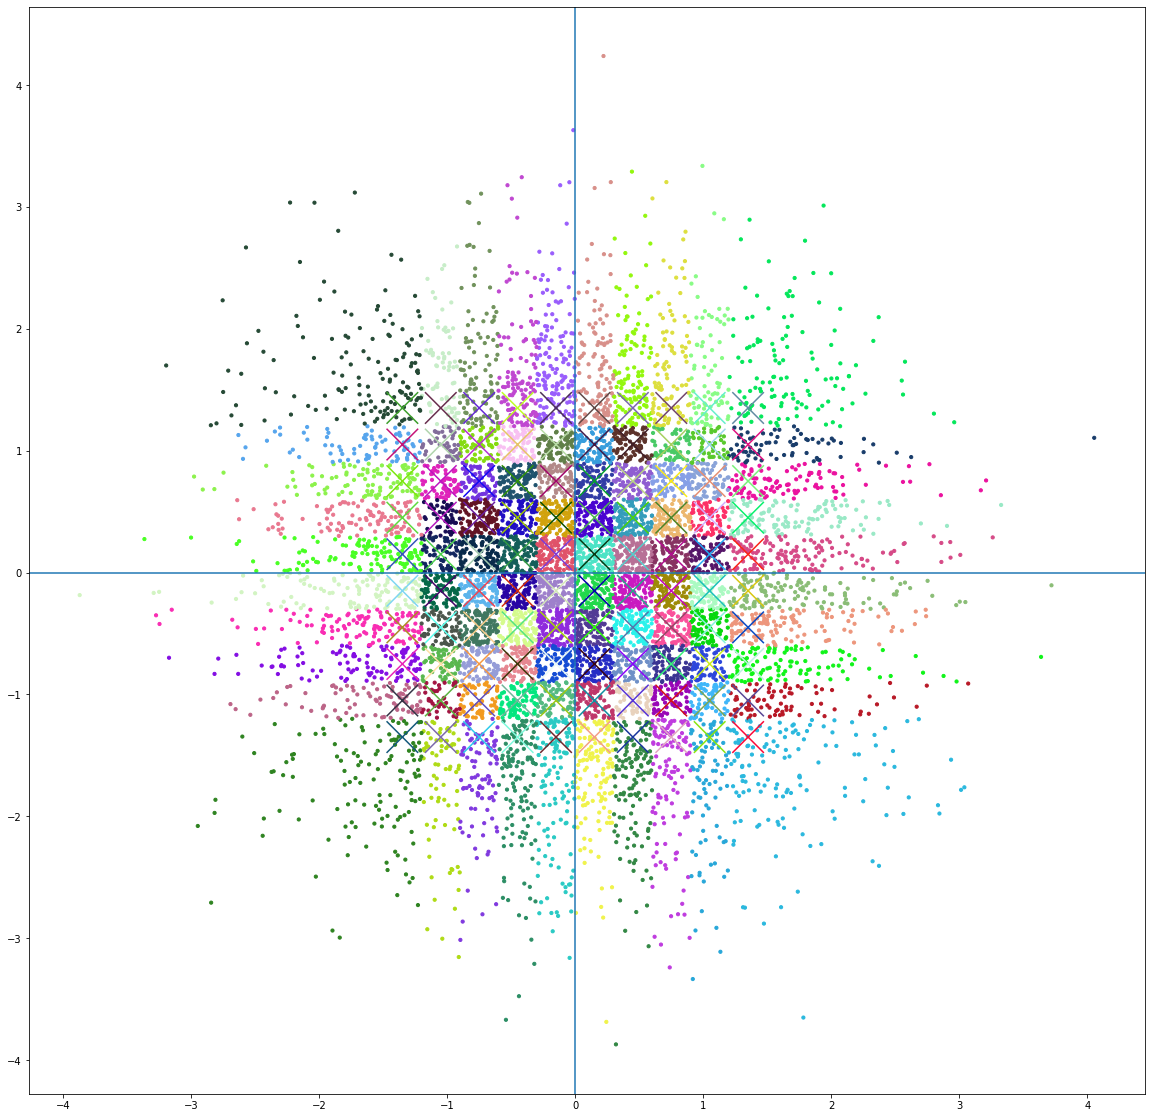

In [354]:
del DiscretizeContinuousSpace
from discrete_prob import DiscretizeContinuousSpace
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, np.ones(2, dtype=int)*10)


plt.figure(figsize=(20, 20))
c = np.random.rand(100, 3)
x = np.random.randn(10000, 2)
idx = dcs.vec2bin(x)
plt.scatter(*x.T, c=c[idx], s=10)

idx = np.arange(0, 100)
v = dcs.bin2vec(idx)
c = np.random.rand(100, 3)
plt.scatter(*v.T, c=c[idx], s=1000, marker='x')

plt.gca().axhline(0)
plt.gca().axvline(0)

In [47]:
ds.x.shape

torch.Size([8998, 11, 3])

In [48]:
for batch_idx in torch.randperm(len(ds.x)).split(32):
    data = {key: value[batch_idx] for key, value in ds.ds.items()}

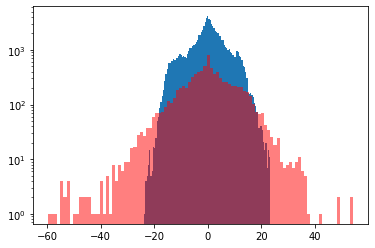

In [49]:
plt.hist(ds.v[:, 1:, 0].flatten().numpy(), bins=100);
plt.hist(ds.v[:, 0, 0].flatten().numpy(), bins=100, color=[1,0,0,.5]);
plt.yscale('log')
plt.show()

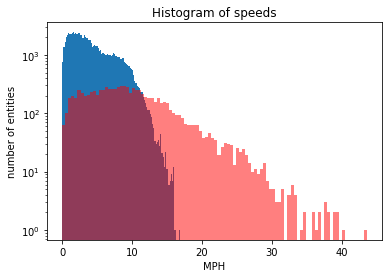

In [50]:
speed = (ds.v.norm(dim=-1))
plt.title('Histogram of speeds')
plt.xlabel('MPH'); plt.ylabel('number of entities')
plt.hist(speed[:, 1:].flatten().numpy()/1.467, bins=100, label='Players');
plt.hist(speed[:, 0].flatten().numpy()/1.467, bins=100, color=[1,0,0,.5], label='Ball');
plt.yscale('log')

In [724]:
v = ds.v

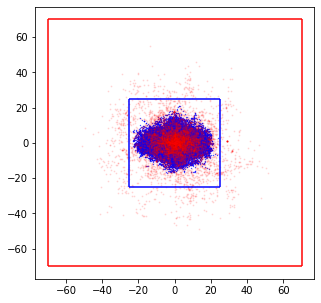

In [725]:
plt.figure(figsize=(5,5))
plt.scatter(v[:, 1:, 0].flatten().numpy(), v[:, 1:, 1].flatten().numpy(), s=.1, color=[0., 0., 1., 1.])
plt.vlines([-max_speed_human, max_speed_human], -max_speed_human, max_speed_human, color='b')
plt.hlines([-max_speed_human, max_speed_human], -max_speed_human, max_speed_human, color='b')

plt.scatter(v[:, 0, 0].flatten().numpy(), v[:, 0, 1].flatten().numpy(), s=1, color=[1., 0, 0, .1])
plt.vlines([-max_speed_ball, max_speed_ball], -max_speed_ball, max_speed_ball, color='r')
plt.hlines([-max_speed_ball, max_speed_ball], -max_speed_ball, max_speed_ball, color='r')
plt.show()


(0.0, 50.0)

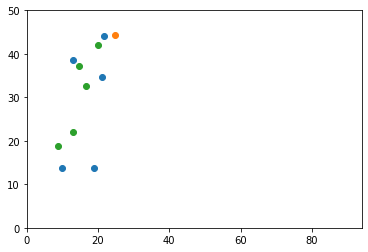

In [726]:
frame_idx = 50
plt.scatter(*ds.x[frame_idx, 1:6][:, :2].numpy().T)
plt.scatter(*ds.x[frame_idx, :1][:, :2].numpy().T)
plt.scatter(*ds.x[frame_idx, 6:][:, :2].numpy().T)
plt.xlim(0, 94)
plt.ylim(0, 50)

4


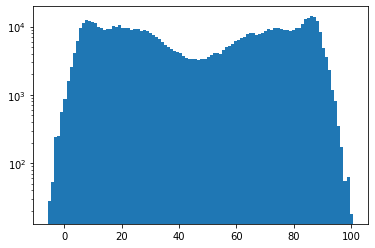

tensor(-5.6625) tensor(100.6232) tensor(47.4659) tensor(28.8095)
5


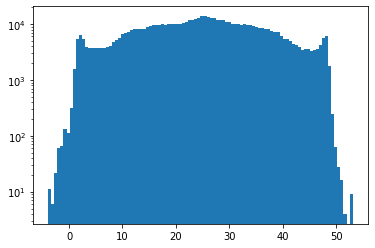

tensor(-3.8903) tensor(53.0736) tensor(24.8453) tensor(11.4727)
6


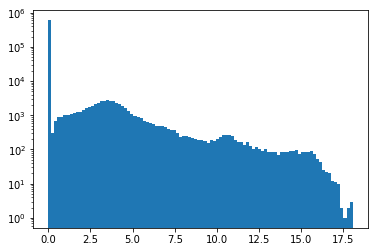

tensor(0.) tensor(18.0520) tensor(0.3985) tensor(1.5477)
7


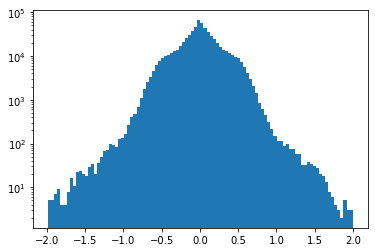

tensor(-1.9840) tensor(1.9969) tensor(0.0012) tensor(0.2870)
8


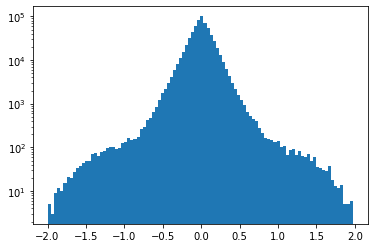

tensor(-1.9902) tensor(1.9715) tensor(-0.0013) tensor(0.1888)
9


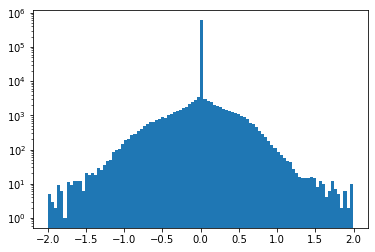

tensor(-1.9923) tensor(1.9872) tensor(0.0003) tensor(0.1248)
10


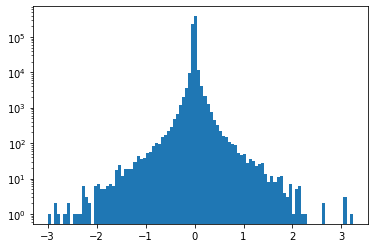

tensor(-2.9866) tensor(3.2281) tensor(1.3718e-05) tensor(0.0737)
11


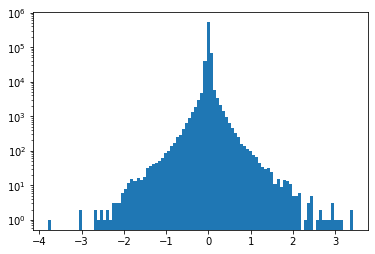

tensor(-3.7918) tensor(3.4168) tensor(8.9651e-06) tensor(0.0926)
12


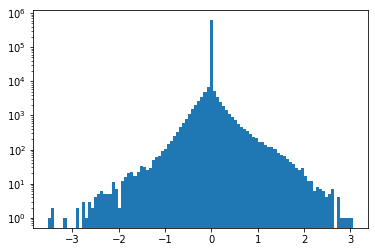

tensor(-3.5229) tensor(3.0504) tensor(-3.6099e-05) tensor(0.1169)


In [190]:
for i in range(4, 13):
    print(i)
    a = ds.x[:, :, i]
    plt.hist(a.flatten().numpy(), bins=100);
    plt.yscale('log');plt.show()
    print(a.min(), a.max(), a.mean(), a.std())

In [460]:
dl = DataLoader(ds, 32, shuffle=True)

In [465]:
for x_batch, y_batch in tqdm(dl):
    # x_batch, y_batch = (x_batch-x_mean)/x_std, (y_batch-y_mean)/y_std
    assert not (x_batch.isnan().any())
    assert not (y_batch.isnan().any())
    
    # plt.plot(x_batch.mean(dim=(0,1)).numpy())
    # plt.plot(x_batch.std(dim=(0,1)).numpy())
    break

  0%|          | 0/1882 [00:00<?, ?it/s]

torch.Size([32, 11, 13]) torch.Size([32, 11])


In [465]:
x = dg[:, 5]
y = dg[:, 6]
print(x.mean(), x.std())
print(y.mean(), y.std())

47.07256216789126 26.851381208031167
25.27347185436629 11.04421297043111


In [468]:
print(94/2., np.sqrt(1/12.)*(94.))
print(50/2., np.sqrt(1/12.)*(50.))

47.0 27.13546265191241
25.0 14.433756729740644


# things to track for this experiment:
- ball x, ball y
- p1 x, p1 y, p1 vx, p1 vy, p1 ax, p1 ay
- ...


# outputs
- movements


In [61]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, final_dim=None, dropout=0.):
        super().__init__()
        if final_dim is None:
            final_dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, final_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    
class ModelNet(nn.Module):
    def __init__(self, n_inputs=13, n_outputs=3, embed_dim=60, n_heads=4, mlp_dim=100, n_layers=5, dropout=0.0, residual=True):
        super().__init__()
        self.lin_in = nn.Linear(n_inputs, embed_dim)
        self.residual = residual
        
        self.norms1 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.attns = nn.ModuleList([nn.MultiheadAttention(embed_dim, n_heads, batch_first=True, dropout=dropout) for _ in range(n_layers)])
        
        self.mlps = nn.ModuleList([MLP(embed_dim, mlp_dim, dropout=dropout) for _ in range(n_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        
        self.lin_out = nn.Linear(embed_dim, n_outputs)
        
    def forward(self, x):
        
        x = self.lin_in(x)
        
        # norm attention res, norm mlp res
        for i_layer, (norm1, attn, norm2, mlp) in enumerate(zip(self.norms1, self.attns, self.norms2, self.mlps)):
            a = norm1(x)
            a, _ = attn(a, a, a)
            x = x+a if self.residual else a
            
            a = norm2(x)
            a = mlp(a)
            x = x+a if self.residual else a
            
        x = self.lin_out(x)
        
        # return x.tanh()*4.
        return x
    
net = ModelNet()
# net(x_batch).shape

In [62]:
dl = DataLoader(ds, 1024, shuffle=True)

In [72]:
net = ModelNet()
for p in net.parameters():
    p.data[...] = 1e-3*torch.randn_like(p)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for idx_epoch in range(1):
    pbar = tqdm(dl)
    for idx_batch, (x_batch, y_batch) in enumerate(pbar):
        x_batch, y_batch = (x_batch-x_mean)/x_std, (y_batch-y_mean)/y_std
        assert not (x_batch.isnan().any())
        assert not (y_batch.isnan().any())

        y_batch_pred = net(x_batch)
        loss = (y_batch_pred-y_batch).pow(2.).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})



  0%|          | 0/59 [00:00<?, ?it/s]

In [75]:
np.sum([p.numel() for p in net.parameters()])

136223

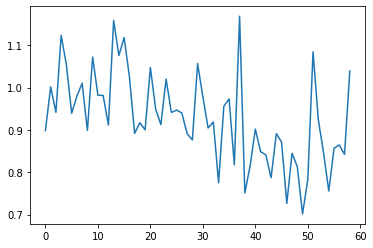

In [73]:
plt.plot(losses)
# plt.ylim(0, 1.)
plt.show()
# plt.plot(np.array(losses).reshape(1, -1).mean(axis=-1))
# plt.show()

In [67]:
net_trained = net

In [68]:
x = ds.x[0]

In [69]:
net_trained(ds.x[300][None])

tensor([[[ 1.7687, -0.1732, -0.9553],
         [ 1.8371,  0.2190, -0.4857],
         [ 3.8098,  0.2376, -0.2783],
         [ 2.8397,  2.2233, -1.7608],
         [ 0.9065,  2.6031, -2.2588],
         [ 2.0179, -0.0531, -0.2550],
         [ 1.5440, -0.1638, -0.3686],
         [ 2.2012, -0.3668, -0.2177],
         [ 1.9179,  0.1847, -0.6012],
         [ 1.1352, -0.2144, -0.3804],
         [ 1.2769,  0.9300, -1.2250]]], grad_fn=<AddBackward0>)

In [71]:
(ds.y[0]-y_mean)/y_std

tensor([[ 7.1347e-01, -4.3416e+00,  8.9022e-02],
        [-6.5337e-02, -5.1932e-02,  1.7719e-05],
        [ 4.2356e-02,  1.3747e-02,  1.7719e-05],
        [ 3.9894e-01, -2.3493e-01,  1.7719e-05],
        [-3.4271e-01,  2.5832e-01,  1.7719e-05],
        [ 2.9064e-02, -1.0206e-01,  1.7719e-05],
        [ 8.8336e-02,  8.1297e-03,  1.7719e-05],
        [ 8.2233e-02, -7.7642e-02,  1.7719e-05],
        [ 2.4771e-01, -4.9413e-03,  1.7719e-05],
        [ 1.4435e-01, -3.8606e-01,  1.7719e-05],
        [-3.1599e-01, -4.1778e-02,  1.7719e-05]])

In [1]:
import torch
from torch import nn

In [9]:
class EncoderNet(nn.Module):
    def __init__(self, n_input=4, embed_dim=60, n_heads=4, n_layers=5):
        super().__init__()
        self.lin_proj = nn.Linear(n_input, embed_dim)
        
        self.attns = nn.ModuleList([nn.MultiheadAttention(embed_dim, n_heads, batch_first=True) for _ in range(n_layers)])
        self.lins = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(n_layers)])
        
    def forward(self, x):
        
        x = self.lin_proj(x)
        
        for i_layer, attn, lin in enumerate(zip(self.attn, self.lins)):
            x = attn(x)
            
            x = lin(x)
        
        return x
    
class OffenseNet(nn.Module):
    def __init__(self, n_outputs=2, encoder=None):
        super().__init__()
        self.encoder = encoder
    def forward(self, x):
        return x
    
class DefenseNet(nn.Module):
    def __init__(self, n_outputs=2, encoder=None):
        super().__init__()
        self.encoder = encoder
    def forward(self, x):
        return x
    
enet = EncoderNet()
onet = OffenseNet()
dnet = DefenseNet()